# Airline Sentiment Analysis using Bayesian Models

This analysis explores Twitter sentiment data for various airlines using two Bayesian approaches:

1. A basic model that estimates overall sentiment probabilities
1. A hierarchical model that accounts for airline-specific differences

Note on interpretation:

- Sentiment categories are: Negative (0), Neutral (1), Positive (2)
- Theta parameters represent probabilities of each sentiment category
- Results are presented with 95% credible intervals

## Data Exploration and Initial Insights

### Data Loading

Load the airline sentiment dataset and examine its structure.

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/Tweets.csv")

# Show basic information about the dataset
df.head()

df.info()

# Time period of the data
df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.date
print(f"Time period from {df['tweet_created'].min()} to {df['tweet_created'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### Data Cleaning

The *airline_sentiment_gold* and *negativereason_gold* columns do not contain much data. Therefore, drop these columns.

In [53]:
df.pop('airline_sentiment_gold')
df.pop('negativereason_gold')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)


### Sentiment Distributions

Inspect the overall sentiment distribution as well as the sentiment distribution by airline.

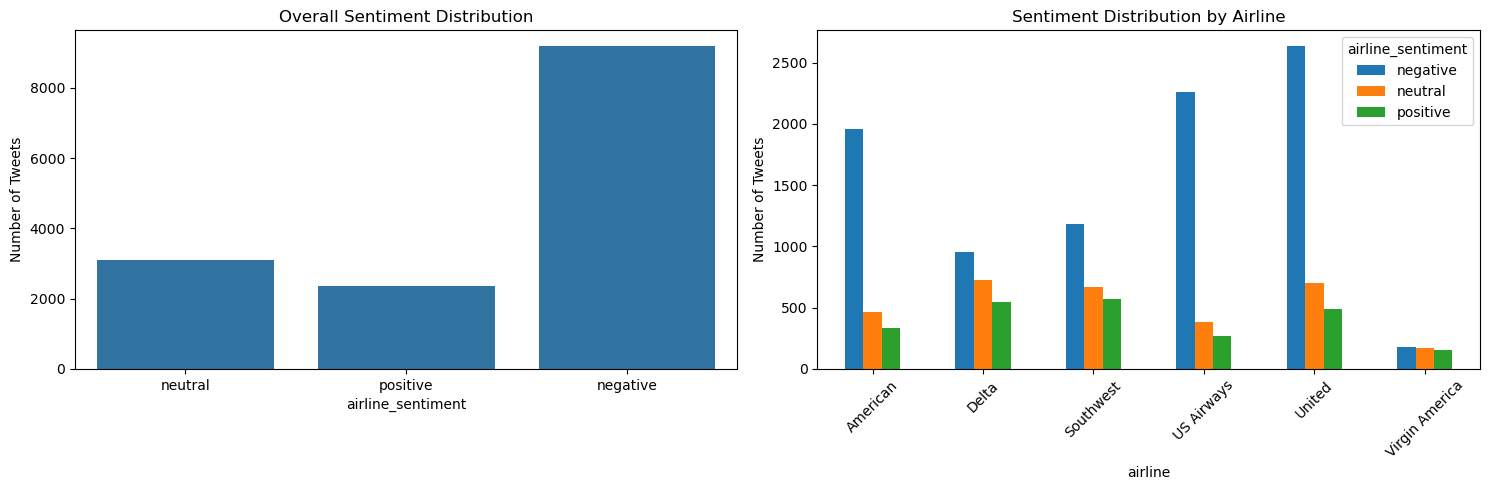


Sentiment distribution (%):
airline_sentiment
negative    62.7
neutral     21.2
positive    16.1
Name: proportion, dtype: float64


In [47]:
# Create sentiment distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Overall sentiment distribution
sns.countplot(data=df, x='airline_sentiment', ax=ax1)
ax1.set_title('Overall Sentiment Distribution')
ax1.set_ylabel('Number of Tweets')

# Sentiment distribution by airline
sentiment_by_airline = pd.crosstab(df['airline'], df['airline_sentiment'])
sentiment_by_airline.plot(kind='bar', ax=ax2)
ax2.set_title('Sentiment Distribution by Airline')
ax2.set_ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print percentage distribution
print("\nSentiment distribution (%):")
print(df['airline_sentiment'].value_counts(normalize=True).round(3) * 100)

### Engagement Analysis

Examining tweet engagement through retweets provides insight into which types of feedback gain more traction.

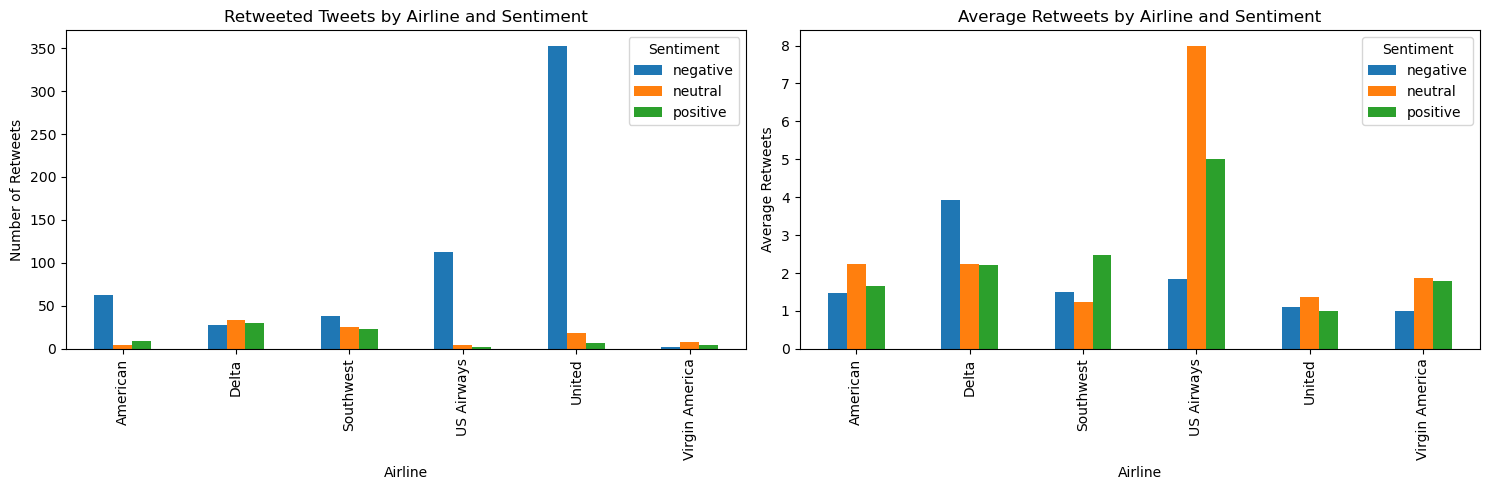

In [55]:
# Analyze retweeted tweets
df_retweeted = df[df['retweet_count'] > 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Number of retweeted tweets by sentiment and airline
retweeted_counts = df_retweeted.groupby(['airline', 'airline_sentiment']).size().unstack()
retweeted_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Retweeted Tweets by Airline and Sentiment')
ax1.set_xlabel('Airline')
ax1.set_ylabel('Number of Retweets')
ax1.legend(title='Sentiment')

# Average retweets when retweeted
avg_retweets = df_retweeted.groupby(['airline', 'airline_sentiment'])['retweet_count'].mean().unstack()
avg_retweets.plot(kind='bar', ax=ax2)
ax2.set_title('Average Retweets by Airline and Sentiment')
ax2.set_xlabel('Airline')
ax2.set_ylabel('Average Retweets')
ax2.legend(title='Sentiment')

plt.tight_layout()
plt.show()

### User Activity

Inspect user tweeting patterns for possible signs of spammers or bots.

In [58]:
# Analyze user tweeting patterns
user_tweet_counts = df['name'].value_counts()

print("Top users by number of tweets:")
print(user_tweet_counts.head(10))
    
# Get the most active user's name and tweets
most_active_user = df['name'].value_counts().index[0]
most_active_user_tweets = df[df['name'] == most_active_user]

# Visually inspect tweets from most active user
print(f"Sample tweets from user: {most_active_user}")
print("-" * 80)

sample_tweets = df[df['name'] == most_active_user][['tweet_created', 'airline', 'airline_sentiment', 'text']].head(5)

# Format and display each tweet
for idx, tweet in sample_tweets.iterrows():
    print(f"Date: {tweet['tweet_created']}")
    print(f"Airline: {tweet['airline']}")
    print(f"Sentiment: {tweet['airline_sentiment']}")
    print(f"Tweet: {tweet['text']}")
    print("-" * 80)

# Calculate sentiment distribution
sentiment_distribution = most_active_user_tweets['airline_sentiment'].value_counts()
sentiment_percentages = (sentiment_distribution / len(most_active_user_tweets) * 100).round(2)

print(f"\nSentiment distribution for {most_active_user}'s tweets:")
print(f"Total tweets: {len(most_active_user_tweets)}")
for sentiment, percentage in sentiment_percentages.items():
    print(f"{sentiment}: {percentage}% ({sentiment_distribution[sentiment]} tweets)")

Top users by number of tweets:
name
JetBlueNews        63
kbosspotter        32
_mhertz            29
otisday            28
throthra           27
weezerandburnie    23
rossj987           23
GREATNESSEOA       22
MeeestarCoke       22
scoobydoo9749      21
Name: count, dtype: int64
Sample tweets from user: JetBlueNews
--------------------------------------------------------------------------------
Date: 2015-02-20
Airline: Virgin America
Sentiment: neutral
Tweet: @VirginAmerica achieves a second year of profitability despite revenue pressure ... - @CAPA_Aviation http://t.co/zSuZTNAIJq
--------------------------------------------------------------------------------
Date: 2015-02-21
Airline: Delta
Sentiment: neutral
Tweet: @JetBlue Fliers to Gain Access to WSJ Content - Analyst Blog - Nasdaq http://t.co/dWEse7Xidr
--------------------------------------------------------------------------------
Date: 2015-02-21
Airline: Delta
Sentiment: neutral
Tweet: @JetBlue Airways Now Covered by Bank o

### Findings

The following observations were made from the exploratory analysis:

- There are significantly more tweets of negative sentiment than of neutral or positive sentiment
- Sentiment distribution varies across airlines
- Negative sentiments tend to get more engagement through retweets
- The user with the highest number of tweets seems to be a bot that shares news with a predominantly neutral sentiment

It was decided to focus the Bayesian modeling effort on:
- Modeling overall sentiment probabilities
- Creating airline-specific sentiment models

This approach will allow us to:
- Understand the underlying sentiment distribution
- Identify airline-specific patterns
- Quantify uncertainty in our estimates

## Sentiment Analysis

### Data Cleaning

Clean the data and prepare it for Bayesian modeling. Map sentiment categories to numerical values and create airline-specific datasets.

In [60]:
# Clean the dataset
df = df[['airline_sentiment', 
         'airline', 
         'text',
         'tweet_created']]

# Map sentiment categories to numerical values (required for PyMC's categorical distribution)
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_categories'] = df['airline_sentiment'].map(sentiment_map)

# Create airline-specific datasets
airlines = df['airline'].unique()
airline_data = {
    airline: {
        'counts': df[df['airline'] == airline]['sentiment_categories'].value_counts().reindex([0, 1, 2], fill_value=0).values,
        'total': len(df[df['airline'] == airline])
    }
    for airline in airlines
}

# Display the first few rows of the cleaned dataset
df.head()

,airline_sentiment,airline,text,tweet_created,sentiment_categories
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,2015-02-24,1
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,2015-02-24,2
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,1
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,2015-02-24,0
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,2015-02-24,0


### Basic Bayesian Model

Implement a simple Dirichlet-Categorical model to estimate overall sentiment probabilities across all airlines. Include prior selection and posterior analysis.

Initializing NUTS using jitter+adapt_diag...


Number of tweets per sentiment category (negative, neutral, positive): [9178 3099 2363]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


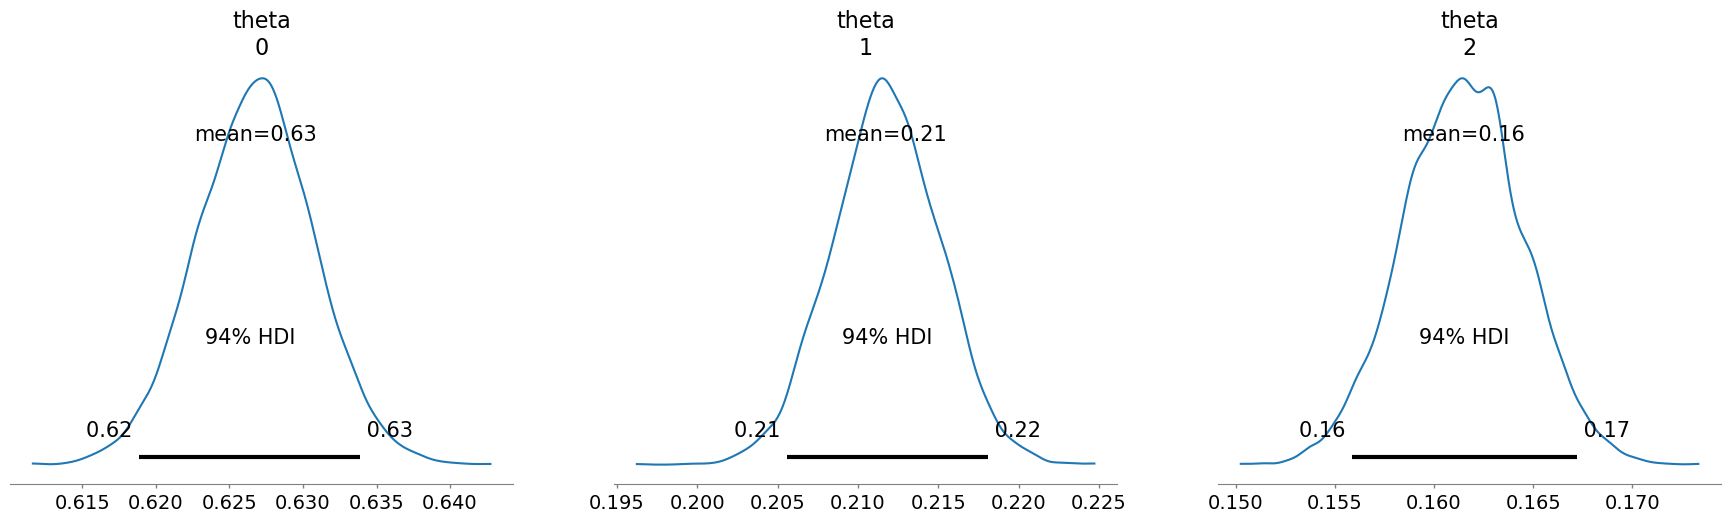

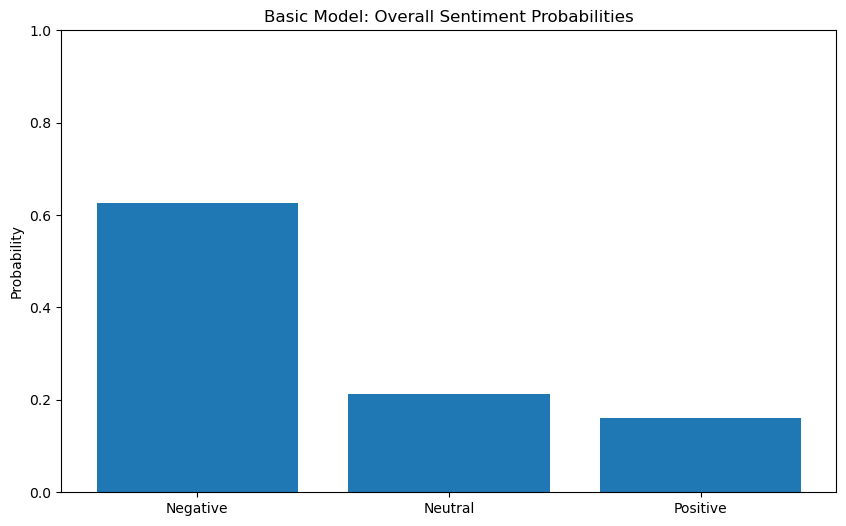

In [ ]:
import pymc as pm
import numpy as np
import arviz as az

# Count the number of tweets in each sentiment category
sentiment_counts = df['airline_sentiment'].value_counts().sort_index().values
print(f"Number of tweets per sentiment category (negative, neutral, positive): {sentiment_counts}")

# Set a prior: symmetric Dirichlet prior
alpha_prior = np.array([1, 1, 1])  # Weak prior, assumes no prior knowledge

# Define the model
with pm.Model() as basic_model:
    # Dirichlet prior for probabilities of each sentiment
    theta = pm.Dirichlet("theta", a=alpha_prior)
    
    # Observed categorical data
    observed = pm.Categorical("observed", p=theta, observed=np.repeat([0, 1, 2], sentiment_counts))
    
    # Sample from the posterior
    basic_trace = pm.sample(2000, return_inferencedata=True)

# Summary of posterior distributions
az.summary(basic_trace, var_names=["theta"])

# # Plot posterior distributions
# az.plot_posterior(basic_trace, var_names=["theta"])
# plt.show()

# Create meaningful labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']
airline_labels = df['airline'].unique()

# Basic Model Plots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, sentiment in enumerate(sentiment_labels):
    az.plot_posterior(basic_trace, 
                     var_names="theta", 
                     coords={'theta_dim_0': i}, 
                     ax=axs[i])
    axs[i].set_title(f"Basic Model: {sentiment} Sentiment")
    axs[i].set_xlabel("Probability")

plt.tight_layout()
plt.show()

def plot_basic_sentiment_probabilities(basic_trace):
    plt.figure(figsize=(10, 6))
    
    # Extract posterior means
    posterior_means = az.summary(basic_trace, var_names=['theta'])
    
    # Create bar plot
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    values = [posterior_means.loc[f'theta[{i}]', 'mean'] for i in range(3)]
    
    plt.bar(sentiment_labels, values)
    plt.ylim(0, 1)
    plt.title('Basic Model: Overall Sentiment Probabilities')
    plt.ylabel('Probability')
    plt.show()

# Plot the basic model results
plot_basic_sentiment_probabilities(basic_trace)

### Hierarchical Bayesian Model

Develop a hierarchical model to account for airline-specific sentiment distributions, using a population-level prior and airline-specific parameters.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_population, concentration, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


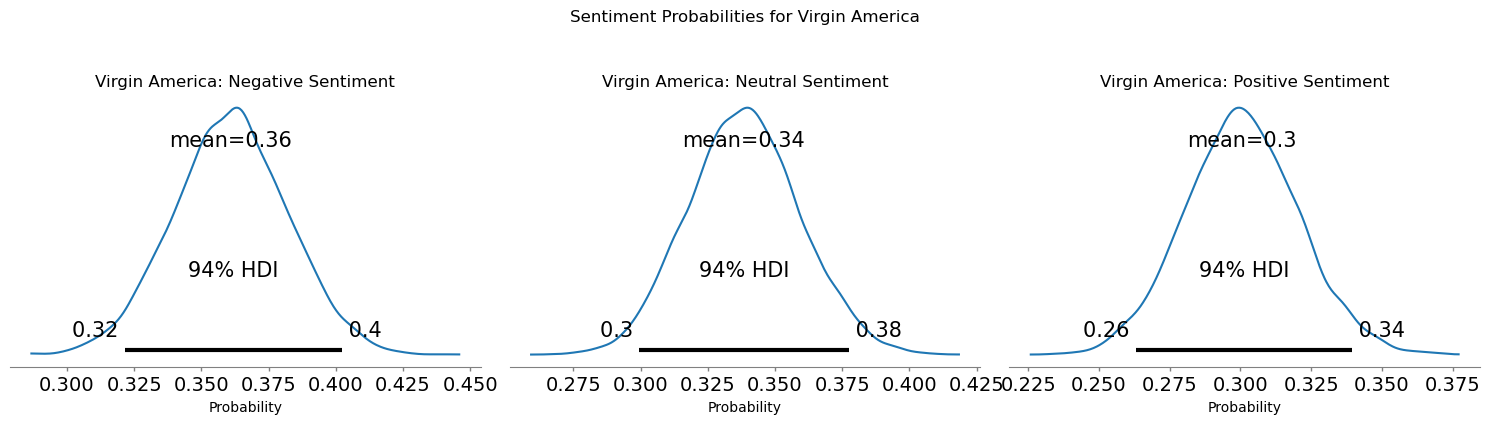

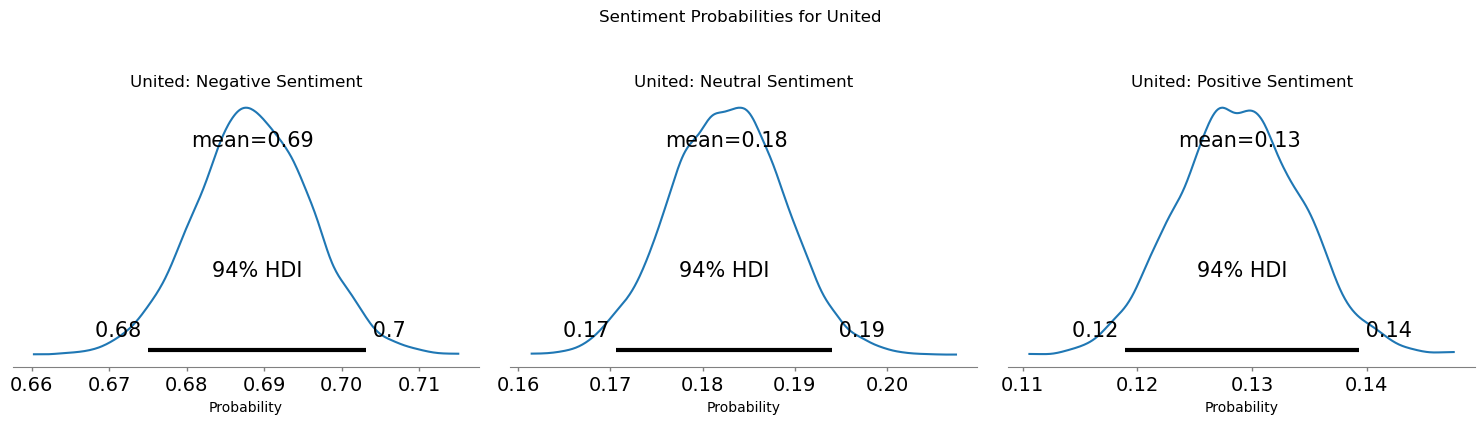

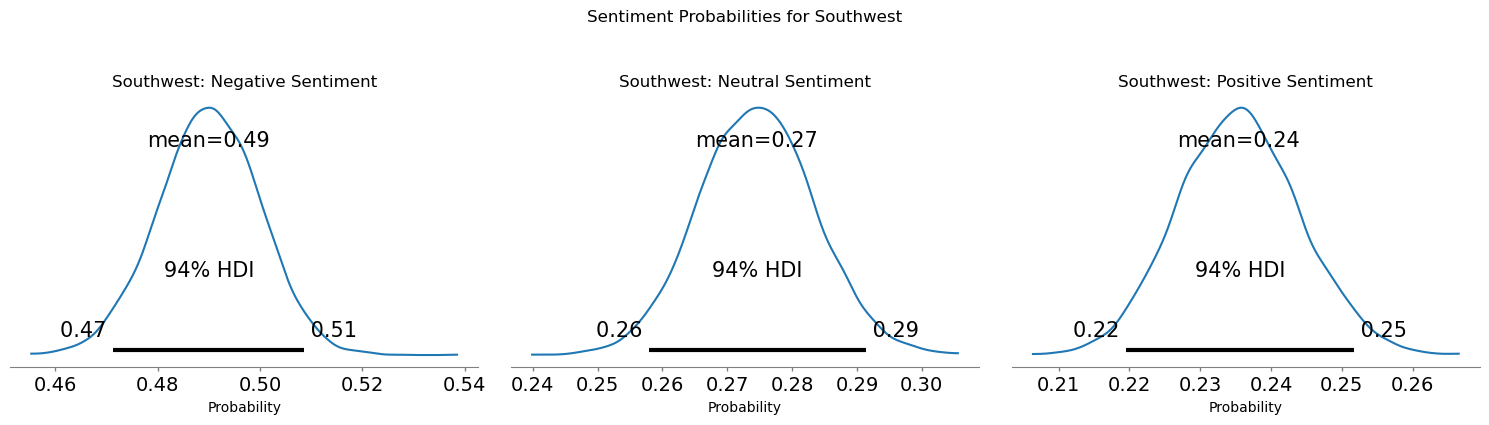

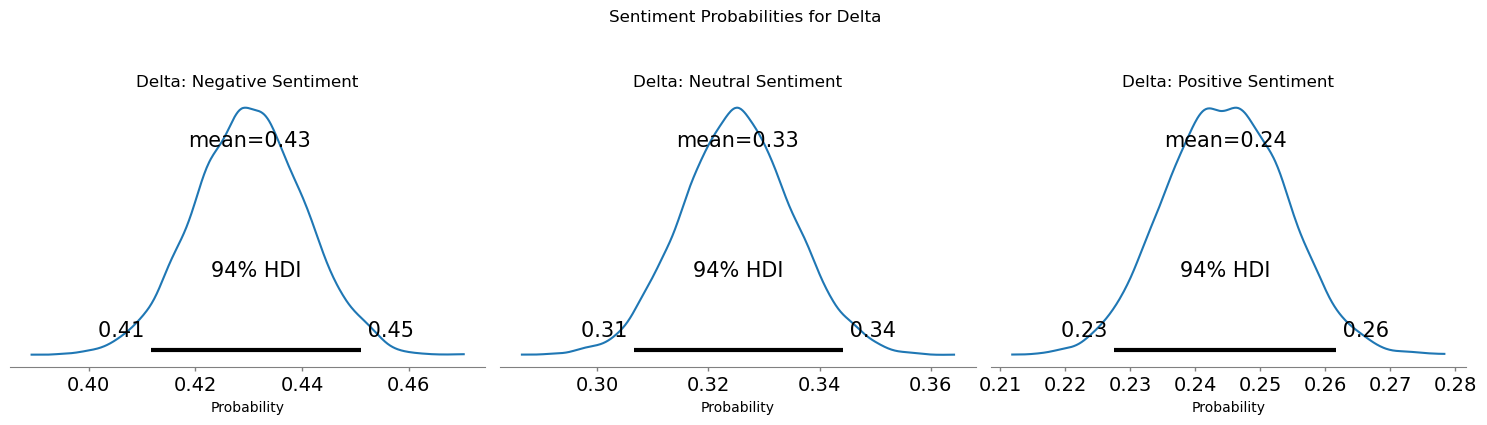

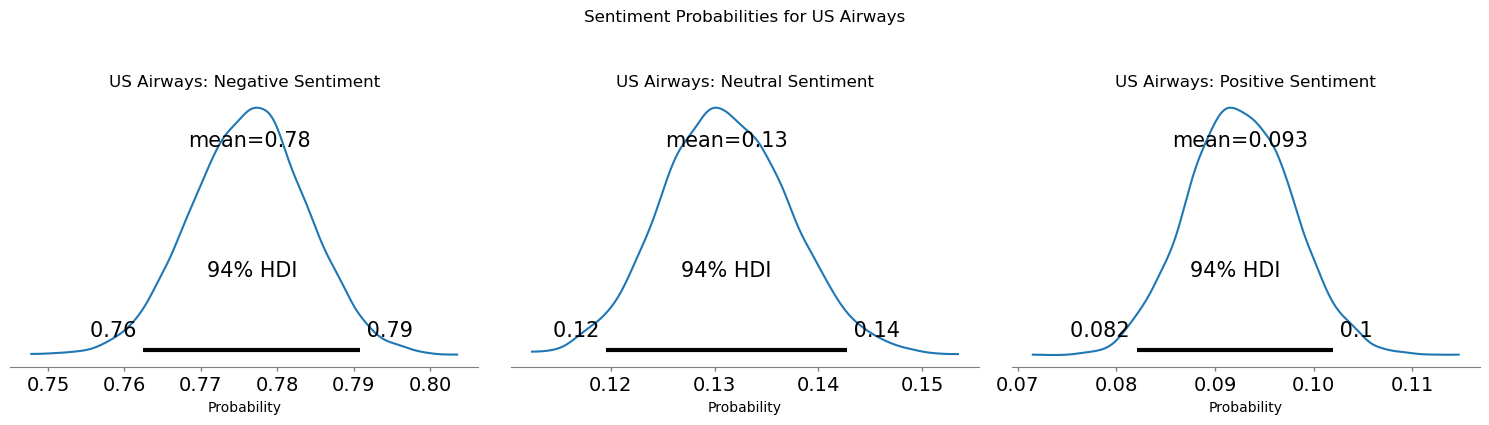

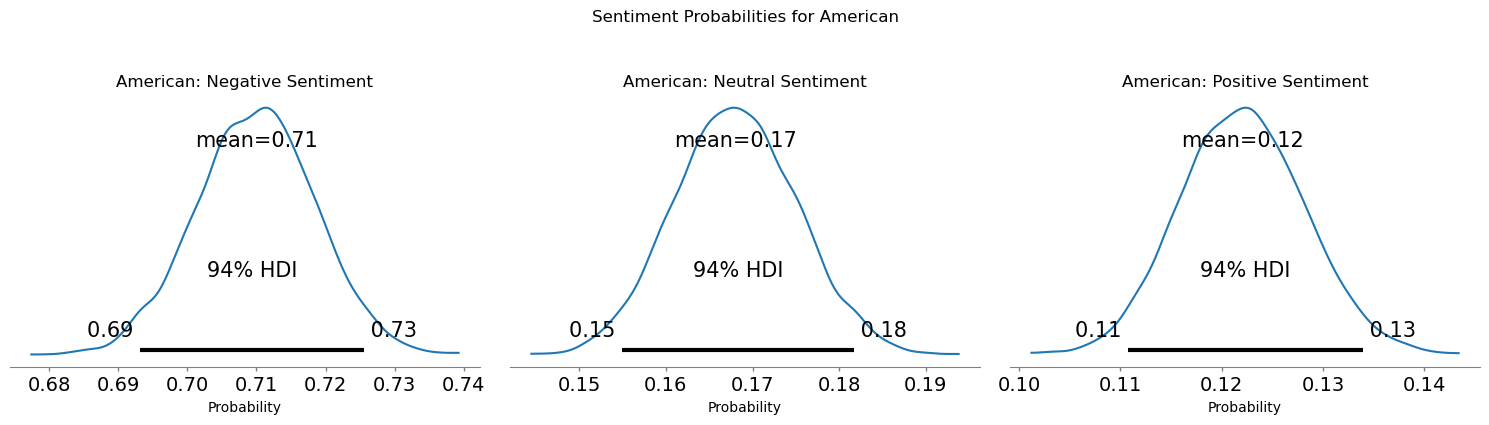

Available parameters in trace:
['theta[0, 0]', 'theta[0, 1]', 'theta[0, 2]', 'theta[1, 0]', 'theta[1, 1]']


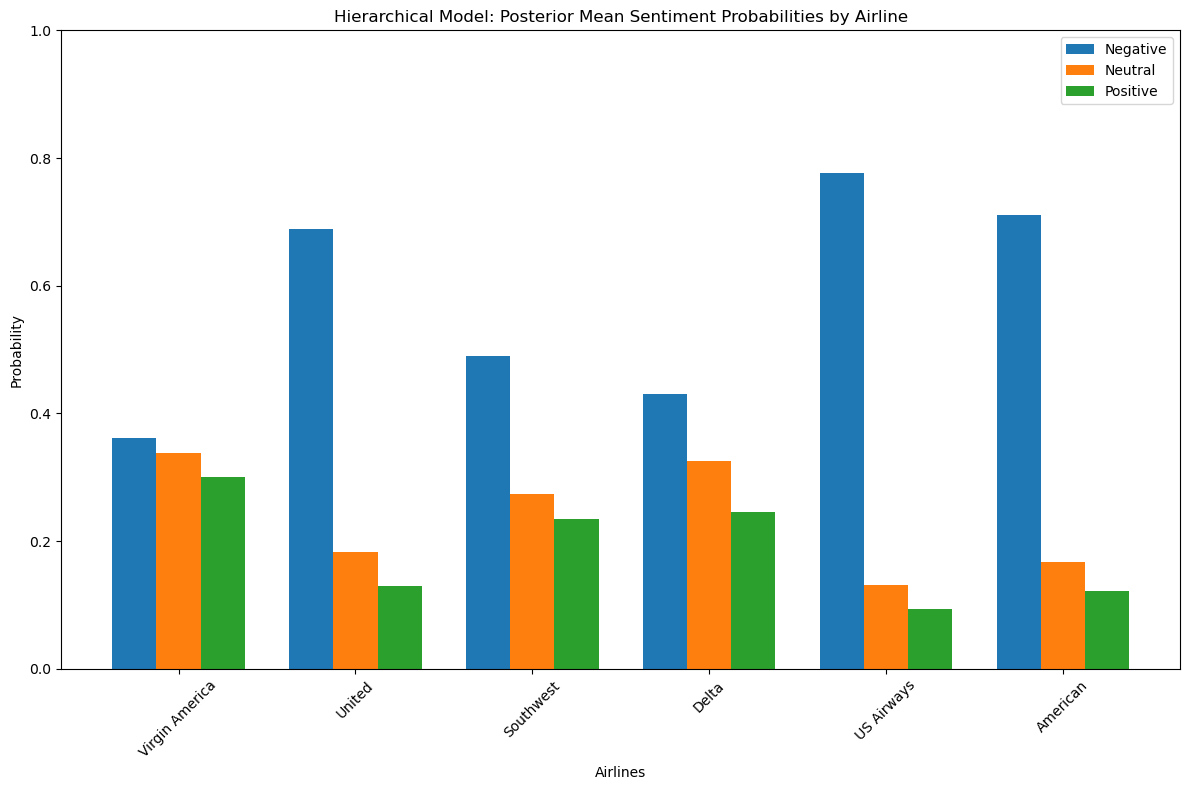

In [70]:
# Define the hierarchical model
with pm.Model() as hierarchical_model:
    # Hyperpriors for the population-level sentiment distribution
    alpha_population = pm.Dirichlet('alpha_population', a=np.ones(3))
    
    # Concentration parameter for airline-specific distributions
    concentration = pm.Gamma('concentration', alpha=2, beta=1)
    
    # Airline-specific sentiment distributions
    theta = pm.Dirichlet('theta',
                         a=(alpha_population * concentration)[None, :],
                         shape=(len(airlines), 3))
    
    # Observations for each airline
    for i, airline in enumerate(airlines):
        pm.Categorical(f'obs_{airline}',
                       p=theta[i],
                       observed=np.repeat([0, 1, 2], 
                                          airline_data[airline]['counts']))

    # Sample from posterior
    hierarchical_trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# # Plot results
# az.plot_posterior(hierarchical_trace, var_names=['theta'])
# plt.show()

# Create meaningful labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']
airline_labels = df['airline'].unique()

# Hierarchical Model Plots - one plot per airline
for airline_idx, airline in enumerate(airline_labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    
    for sent_idx, sentiment in enumerate(sentiment_labels):
        az.plot_posterior(hierarchical_trace, 
                         var_names="theta", 
                         coords={'theta_dim_0': airline_idx,
                                'theta_dim_1': sent_idx},
                         ax=axs[sent_idx])
        axs[sent_idx].set_title(f"{airline}: {sentiment} Sentiment")
        axs[sent_idx].set_xlabel("Probability")
    
    plt.suptitle(f"Sentiment Probabilities for {airline}", y=1.05)
    plt.tight_layout()
    plt.show()


# Add visualization of differences between airlines
def plot_sentiment_comparisons(hierarchical_trace, airlines):
    plt.figure(figsize=(12, 8))
    
    # Extract posterior means for each airline
    posterior_means = az.summary(hierarchical_trace, var_names=['theta'])
    
    # Create sentiment comparison plot
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    x = np.arange(len(airlines))
    width = 0.25

    for i, sentiment in enumerate(sentiment_labels):
        values = []
        for j in range(len(airlines)):
            key = f'theta[{j}, {i}]'
            values.append(posterior_means.loc[key, 'mean'])

        plt.bar(x + i*width, values, width, label=sentiment)

    plt.xlabel('Airlines')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.title('Hierarchical Model: Posterior Mean Sentiment Probabilities by Airline')
    plt.xticks(x + width, airlines, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Let's verify the structure of the posterior summary first
print("Available parameters in trace:")
print(az.summary(hierarchical_trace, var_names=['theta']).index.tolist()[:5])  # Show first 5 indices

# Now plot
plot_sentiment_comparisons(hierarchical_trace, airlines)

## Model Comparison and Evaluation

Compare the models using appropriate metrics, visualize results, and draw conclusions about airline sentiment patterns. Include uncertainty quantification and interpretation.

A forest plot shows the posterior distributions for each parameter (theta) in both models:

- Each horizontal line represents a 95% credible interval
- The point in the middle represents the posterior mean
- Narrower intervals indicate more certainty in the estimate
- The hierarchical model shows separate estimates for each airline, while the basic model shows overall sentiment probabilities

This plot shows the mean estimates (dots) and 95% credible intervals (horizontal lines) for:

- Basic Model: Overall sentiment probabilities
- Hierarchical Model: Airline-specific sentiment probabilities


Basic Model Summary:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.627  0.004   0.619    0.634        0.0      0.0    6669.0   
theta[1]  0.212  0.003   0.206    0.218        0.0      0.0    7067.0   
theta[2]  0.161  0.003   0.156    0.167        0.0      0.0    7372.0   

          ess_tail  r_hat  
theta[0]    5701.0    1.0  
theta[1]    5292.0    1.0  
theta[2]    6254.0    1.0  

Hierarchical Model Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0, 0]  0.361  0.021   0.323    0.402        0.0      0.0   13575.0   
theta[0, 1]  0.339  0.021   0.299    0.377        0.0      0.0   13165.0   
theta[0, 2]  0.300  0.020   0.265    0.340        0.0      0.0   12756.0   
theta[1, 0]  0.689  0.007   0.675    0.703        0.0      0.0   15126.0   
theta[1, 1]  0.182  0.006   0.170    0.194        0.0      0.0   14577.0   
theta[1, 2]  0.129  0.006   0.119    0.139        0.0      0.0   16482.0   
theta[2, 0]  

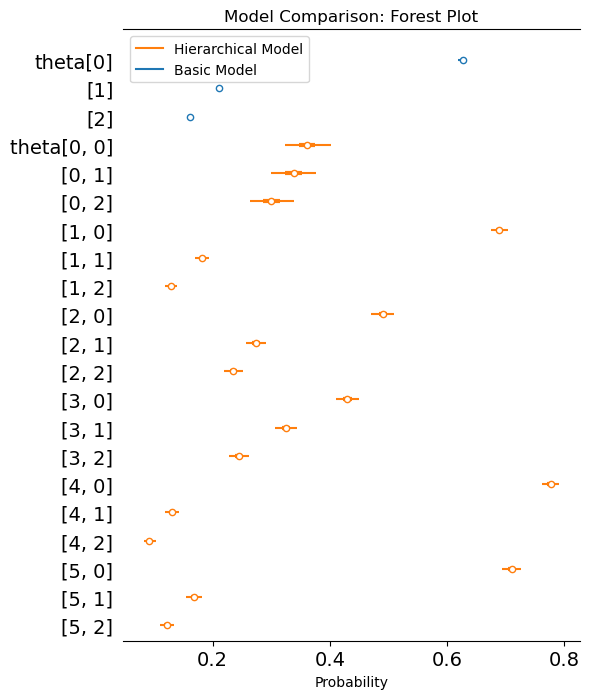

Basic Model HDI:
<xarray.Dataset> Size: 120B
Dimensions:      (theta_dim_0: 3, hdi: 2)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 24B 0 1 2
  * hdi          (hdi) <U6 48B 'lower' 'higher'
Data variables:
    theta        (theta_dim_0, hdi) float64 48B 0.6185 0.6342 ... 0.1556 0.1674

Hierarchical Model HDI:
<xarray.Dataset> Size: 496B
Dimensions:                 (alpha_population_dim_0: 3, hdi: 2, theta_dim_0: 6,
                             theta_dim_1: 3)
Coordinates:
  * alpha_population_dim_0  (alpha_population_dim_0) int64 24B 0 1 2
  * theta_dim_0             (theta_dim_0) int64 48B 0 1 2 3 4 5
  * theta_dim_1             (theta_dim_1) int64 24B 0 1 2
  * hdi                     (hdi) <U6 48B 'lower' 'higher'
Data variables:
    alpha_population        (alpha_population_dim_0, hdi) float64 48B 0.3681 ...
    concentration           (hdi) float64 16B 2.339 10.01
    theta                   (theta_dim_0, theta_dim_1, hdi) float64 288B 0.31...


In [68]:
# Compare the models using appropriate metrics
basic_model_summary = az.summary(basic_trace, var_names=["theta"])
hierarchical_model_summary = az.summary(hierarchical_trace, var_names=["theta"])

# Print summaries for comparison
print("Basic Model Summary:")
print(basic_model_summary)

print("\nHierarchical Model Summary:")
print(hierarchical_model_summary)

# Forest plot with improved labels
az.plot_forest(
    [basic_trace, hierarchical_trace],
    model_names=["Basic Model", "Hierarchical Model"],
    var_names=["theta"],
    combined=True  # This combines the chains into a single summary
)
plt.title("Model Comparison: Forest Plot")
plt.xlabel("Probability")
plt.tight_layout()
plt.show()

# Uncertainty quantification and interpretation
basic_model_hdi = az.hdi(basic_trace, hdi_prob=0.95)
hierarchical_model_hdi = az.hdi(hierarchical_trace, hdi_prob=0.95)

print("Basic Model HDI:")
print(basic_model_hdi)

print("\nHierarchical Model HDI:")
print(hierarchical_model_hdi)

### Model Comparison Visualization

The plots below show:

1. **Basic Model**: Overall sentiment probabilities across all airlines
1. **Hierarchical Model**: Airline-specific sentiment probabilities

The posterior distributions show the probability ranges for each sentiment category, with wider distributions indicating more uncertainty in the estimates.